# 1 

A partir del fichero "US_Crime_Rates_1960_2014", se pide:

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.
2. Dibujar todas las columnas numéricas.
3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas. 
4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación? 
5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.
6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones=23 y n_repeats=7.

In [178]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
seed_value += 1

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
seed_value += 1

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
seed_value += 1

In [179]:
import gc
gc.collect()

18345

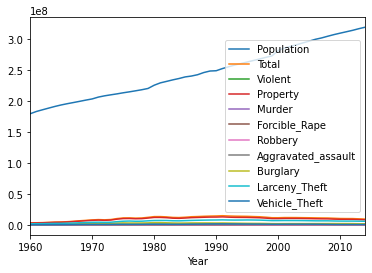

In [180]:
import numpy as np
import random 
#np.random.seed(42)
#random.seed(42)
#random.Random(42)
import pandas as pd

df = pd.read_csv("../data/US_Crime_Rates_1960_2014.csv", low_memory=False)

df.set_index("Year", inplace=True)
df.plot()

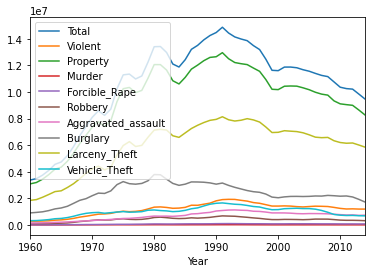

In [181]:
df.loc[:, 'Total':].plot()

In [182]:
df2 = df.loc[:, 'Violent':]
df2.head()

,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
Year,,,,,,,,,
1960,288460,3095700,9110,17190,107840,154320,912100,1855400,328200
1961,289390,3198600,8740,17220,106670,156760,949600,1913000,336000
1962,301510,3450700,8530,17550,110860,164570,994300,2089600,366800
1963,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300
1964,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800


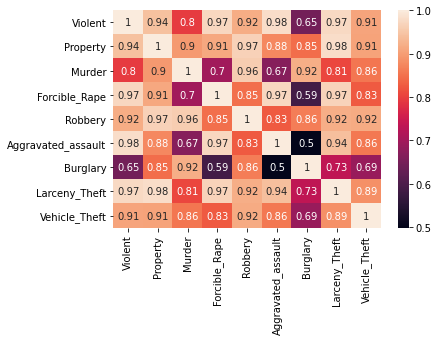

In [183]:
import seaborn as sns

sns.heatmap(df2.corr(), annot=True)

In [184]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs = {'Column_A':[], 'Column_B':[]}
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs['Column_A'].append(cols[i])
            pairs['Column_B'].append(cols[j])
    return pairs

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    pairs = get_redundant_pairs(df)
    tuple_pairs = list(zip(pairs['Column_A'], pairs['Column_B']))

    au_corr = au_corr.drop(labels=tuple_pairs).sort_values(ascending=False)
    df = pd.DataFrame(au_corr[0:n], columns=['Correlation'])
    df.reset_index(inplace=True)
    return df



In [185]:
cors = get_top_abs_correlations(df2, n=40)

In [186]:
cors.head()

,level_0,level_1,Correlation
0,Violent,Aggravated_assault,0.981071
1,Property,Larceny_Theft,0.980528
2,Violent,Larceny_Theft,0.974791
3,Forcible_Rape,Aggravated_assault,0.974379
4,Violent,Forcible_Rape,0.973914


In [187]:
cors[(cors.level_0 == 'Murder') | (cors.level_1 == 'Murder')].head(5)

,level_0,level_1,Correlation
7,Murder,Robbery,0.960156
11,Murder,Burglary,0.920207
17,Property,Murder,0.895641
22,Murder,Vehicle_Theft,0.856600
27,Murder,Larceny_Theft,0.806279


In [188]:
import numpy as np

X = np.array(df2.loc[:, ['Robbery', 'Burglary', 'Property', 'Vehicle_Theft', 'Larceny_Theft']]).astype(np.int64)
y = np.array(df2['Murder']).astype(np.int64)

In [189]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [190]:
np.__version__

'1.19.5'

In [191]:
import warnings

def plot_crossval_scores(X, y, degree=6, splits=23, epochs=7, random_state=42, show_warnings=False):

    if show_warnings == False:
        warnings.filterwarnings('ignore')

    scores = {'Epoch':[],'Iteration':[],'Train_Score':[], 'Val_Score':[],'Train_MAE':[], 'Train_RMSE':[], 'Val_MAE':[], 'Val_RMSE':[]}
    epoch = 1
    iteration = 1

    # Cross Validation Data Collection
    polinominal_model = PolynomialFeatures(degree) 
    X_poly = polinominal_model.fit_transform(X, y)
    #np.random.seed(random_state)
    rkf = RepeatedKFold(n_splits=10, n_repeats=1)
    #np.random.seed(random_state)
    lin_reg_model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2)
    #np.random.seed(random_state)
    for train_index, val_index in rkf.split(X_train):

        lin_reg_model.fit(X_train[train_index], y_train[train_index])
        train_score = lin_reg_model.score(X_train[train_index], y_train[train_index])
        val_score = lin_reg_model.score(X_train[val_index], y_train[val_index])

        scores['Train_Score'].append(train_score)
        scores['Val_Score'].append(val_score)
        scores['Iteration'].append(iteration)
        scores['Epoch'].append(epoch)

        y_pred = lin_reg_model.predict(X_train[train_index])
        y_pred_val = lin_reg_model.predict(X_train[val_index])

        scores['Train_MAE'].append(mean_absolute_error(y_train[train_index], y_pred))
        scores['Train_RMSE'].append(np.sqrt(mean_squared_error(y_train[train_index], y_pred)))
        scores['Val_MAE'].append(mean_absolute_error(y_train[val_index], y_pred_val))
        scores['Val_RMSE'].append(np.sqrt(mean_squared_error(y_train[val_index], y_pred_val)))
        
        iteration += 1
        if iteration > splits:
            iteration = 1
            epoch += 1

    # Epoch Plots
    df = pd.DataFrame(scores, index=range(len(scores['Val_Score'])))

    for e in range(1, epochs+1):
        x_plot = df[df.Epoch == e]['Iteration']
        y_plot_train = df[df.Epoch == e]['Train_Score']
        y_plot_val = df[df.Epoch == e]['Val_Score']
        fig, ax = plt.subplots()
        ax.plot(x_plot, y_plot_train, color='green', label='Train Score')
        ax.plot(x_plot, y_plot_val, color='red', label='Val Score')
        plt.title(f'Train/Val Score | Epoch: {e}')
        ax.legend(loc='best')
        plt.show()

    return df

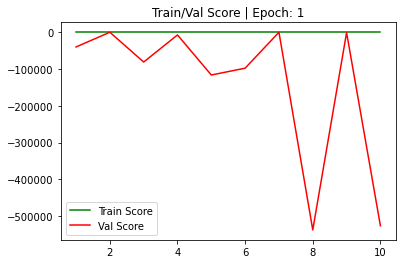

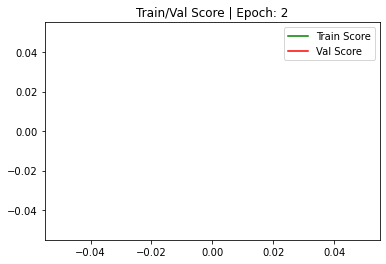

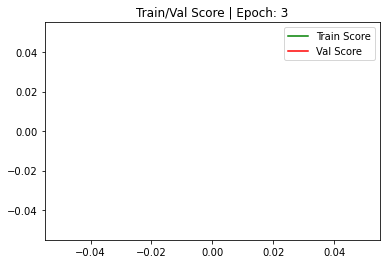

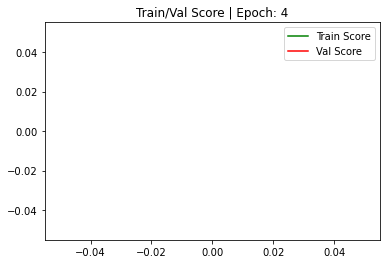

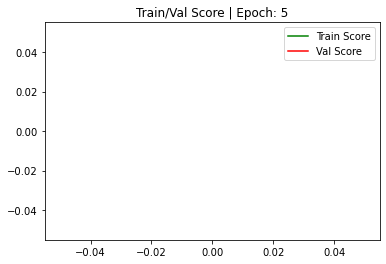

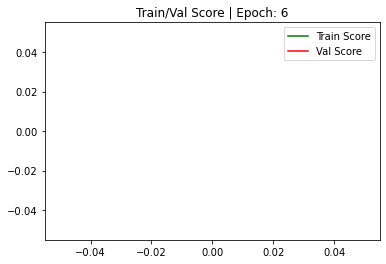

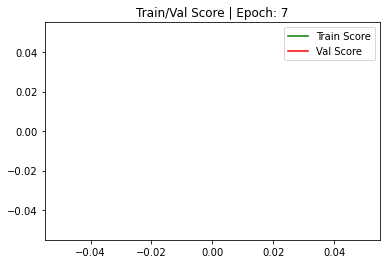

In [192]:
scores = plot_crossval_scores(X, y)

In [193]:
# 1º 0.000337
# 2º 0.000115
# jorge 391
print(scores["Val_Score"][0])
scores

-39982.595766652164


,Epoch,Iteration,Train_Score,Val_Score,Train_MAE,Train_RMSE,Val_MAE,Val_RMSE
0,1,1,1.0,-39982.595767,0.031430,0.043944,3.855956e+05,4.423617e+05
1,1,2,1.0,-2.853221,0.000011,0.000014,4.636212e+03,8.944027e+03
2,1,3,1.0,-80955.194671,0.005144,0.006423,6.888038e+05,7.867351e+05
3,1,4,1.0,-7356.388570,0.001697,0.002135,3.192200e+05,4.496636e+05
4,1,5,1.0,-116205.116105,0.010820,0.015179,1.099262e+06,1.386082e+06
5,1,6,1.0,-97676.369339,0.035291,0.049111,7.557266e+05,8.244113e+05
6,1,7,1.0,-27.459211,0.000117,0.000162,2.246848e+04,3.329970e+04
7,1,8,1.0,-537198.132259,0.086030,0.120810,1.609431e+06,2.014711e+06
8,1,9,1.0,-904.084187,0.102482,0.137890,1.137478e+05,1.346770e+05
9,1,10,1.0,-526016.869117,0.014637,0.020820,1.098535e+06,1.225412e+06


In [194]:
def mean_absolute_error(y_predict, y_test):
    return sum(abs(y_predict - y_test))/len(y_test)

def mean_squared_error(y_predict, y_test):
    return sum((y_predict - y_test)**2)/len(y_test)

def root_mean_sqr_error(y_predict, y_test):
    return np.sqrt(mean_squared_error(y_predict, y_test))

polinominal_model = PolynomialFeatures(6) 
X_poly = polinominal_model.fit_transform(X, y)
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
lin_reg_model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
for train_index, val_index in rkf.split(X_train):
    lin_reg_model.fit(X_train[train_index], y_train[train_index])
    break

y_pred = lin_reg_model.predict(X_train[train_index])

print('MAE:', mean_absolute_error(y_pred, y_train[train_index]))
print('RMSE:', mean_squared_error(y_pred, y_train[train_index]))

MAE: 0.00011491860753337208
RMSE: 3.2645463305968766e-08


In [195]:
polinominal_model = PolynomialFeatures(6) 
X_poly = polinominal_model.fit_transform(X, y)
rkf = RepeatedKFold(n_splits=23, n_repeats=7, random_state=42)
lin_reg_model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
for train_index, val_index in rkf.split(X_train):
    lin_reg_model.fit(X_train[train_index], y_train[train_index])
    break

In [196]:
y_pred = lin_reg_model.predict(X_train[train_index])

In [197]:
print('MAE:', mean_absolute_error(y_pred, y_train[train_index]))
print('RMSE:', mean_squared_error(y_pred, y_train[train_index]))

MAE: 0.00033731313877589334
RMSE: 2.1980848587503902e-07
